### Train the Multi Input Recurrent Neural Network 
created in [Multi_Input3RNN_Perfect_Creation](Multi_Input3RNN_Perfect_Creation.ipynb)

---

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf

import joblib

In [2]:
# import pakages forML
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler,RobustScaler, PowerTransformer
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list, train_split_date, trainVal_split_date

In [5]:
# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
# h_start_end = ('07:00','18:50')
df_data2 = joblib.load(network_folder+'cleanedData.pkl')

h_start_end = ('06:00','19:50')

per_daylight = ( pd.Series(index=df_data2.index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

df_data2 = df_data2.loc[per_daylight]
df_data2 = df_data2[df_data2.index<=train_split_date]



df_data = df_data2.copy(deep=True)
df_data['Month'] = df_data.index.month
df_data['Days'] = df_data.index.day_of_week
df_data['hour'] = df_data.index.hour
df_data['Minutes'] = df_data.index.minute

Δt_minutes = 60*Δt  # Sampling frequency in minutes
freq_minutes = df_data.Minutes.max()+Δt_minutes
freq_day = (len(df_data[(df_data.index>='2021 01 01') & (df_data.index<='2021 01 02')])-1)*Δt_minutes
freq_week = (len(df_data[(df_data.index>='2021 01 01') & (df_data.index<='2021 01 08')])-1)*Δt_minutes
freq_year =  len(df_data[(df_data.index>='2021 01 01') & (df_data.index<='2022 01 01')])*Δt_minutes


# Create Cycling data 
hourly_cycle = np.cos((df_data.Minutes)*2*np.pi/freq_minutes)
daily_cycle =  np.cos((60*df_data.hour+df_data.Minutes)*2*np.pi/freq_day)
weekly_cycle = np.cos((freq_day*df_data.Days + 60*df_data.hour + df_data.Minutes)*2*np.pi/freq_week)
yearly_cycle = np.cos((freq_day*df_data.index.day_of_year+ 60*df_data.hour + df_data.Minutes)*2*np.pi/freq_year)

# Create a dict for the cycling data
cycle_datadict = {name: elm.values for name, elm in zip(['hourly_cycle', 'daily_cycle', 'weekly_cycle', 'yearly_cycle'],
                                                        [hourly_cycle,daily_cycle,weekly_cycle,yearly_cycle])}
df_cycleData = pd.DataFrame(data=cycle_datadict, index=df_data.index) # Transform the cycling data into a dataframe


# # Separate training and validation set  for botht he cycling and the normal data
df_train = df_data[df_data.index< trainVal_split_date]
df_val = df_data[df_data.index>= trainVal_split_date]
df_train_cycle = df_cycleData[df_cycleData.index<trainVal_split_date]
df_val_cycle = df_cycleData[df_cycleData.index>= trainVal_split_date]


#### Separate numeric voltage rise from binary voltage rise

In [6]:
df_vrise = joblib.load('pickle_files/simulationResults/Binary_Voltage_Rise.pkl')
df_bin_Vrise = df_vrise[['Volt_Rise_Bin']]
df_num_Vrise = df_vrise[['known']]

# split training and validation data
df_train_bin_Vrise = df_bin_Vrise[df_bin_Vrise.index< train_split_date]
df_val_bin_Vrise = df_bin_Vrise[df_bin_Vrise.index >= train_split_date]

df_train_num_Vrise = df_num_Vrise[df_num_Vrise.index<train_split_date]
df_val_num_Vrise = df_num_Vrise[df_num_Vrise.index >= train_split_date]


#### Plot data

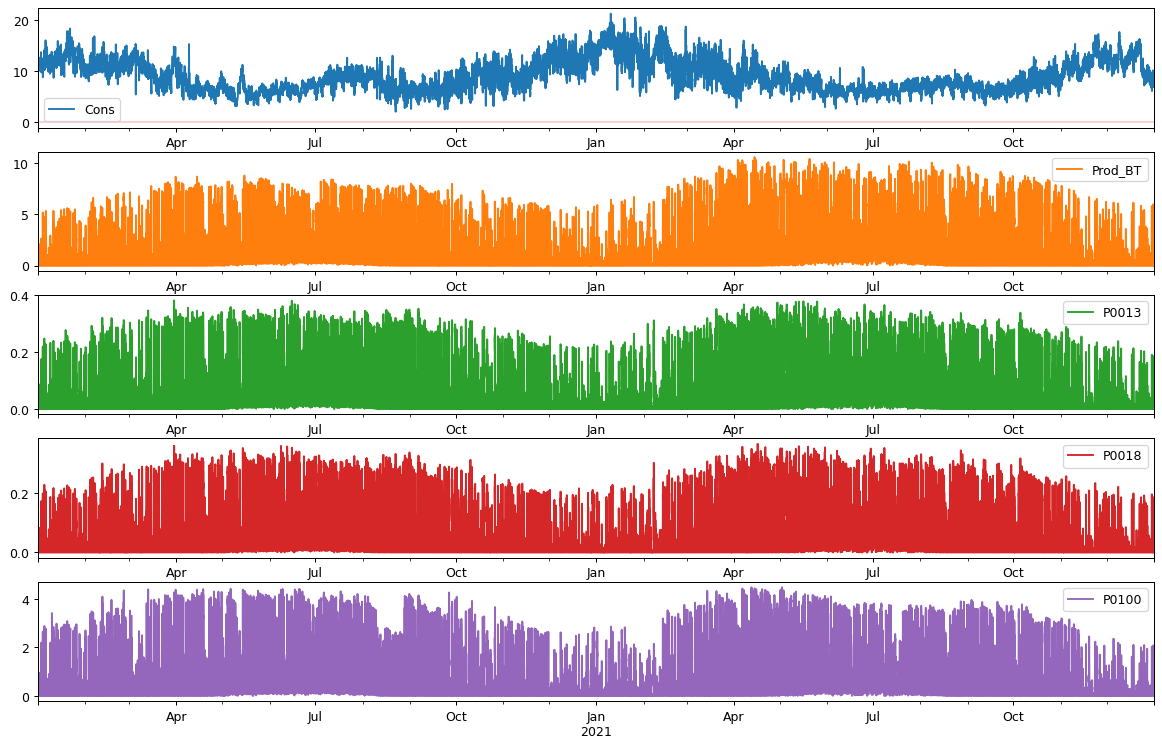

In [7]:
fig, axx = plt.subplots(5,figsize=(16,10),dpi=90)
df_data.iloc[:,:5].plot(subplots=True,ax=axx);
axx[0].axhline(0, color='red', lw=0.3)

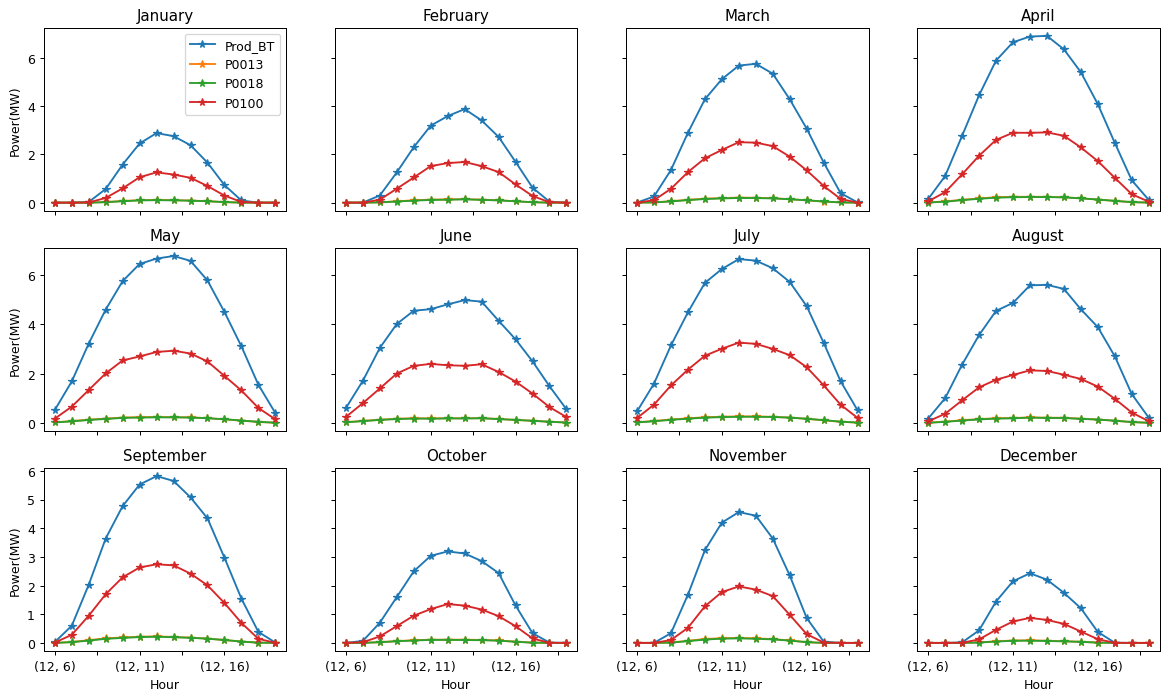

In [11]:
month_names_list = df_train.index.to_timestamp().month_name().unique();
fig, axx = plt.subplots(3,4, figsize=(16,9), dpi=90, sharey='row', sharex=True)
to_plot = df_train.iloc[:,[0,1,2,3,4,5,7]].groupby(by=[ 'Month', 'hour'],).mean().groupby(by='Month')
        

for elm, cur_axx in zip(to_plot, axx.flatten()):
    # Plot legend on the first subplot()
    if elm[0] == 1 :
        elm[1].plot(ax=cur_axx,marker='*',  xlabel='',ylabel = 'Power(MW)', title=month_names_list[elm[0]-1])
        var = day_tot_per//6
        # cur_axx.set_xticks(range(0, var), labels=range(7,7+var))
        # cur_axx.semilogy()
    else:    
        elm[1].plot(ax=cur_axx, marker='*',legend=False, xlabel='Hour', ylabel = 'Power(MW)', title=month_names_list[elm[0]-1])
        # cur_axx.set_xticks(range(0, var), labels=range(7,7+var))
        # cur_axx.set_xticks(range(0,10), labels=range(8,18))
        # cur_axx.semilogy()
        
# fig.tight_layout()

#### Train RNN

In [12]:
# Define Scalers
numerical_scaler = MinMaxScaler()    
numerical_scaler_cycle = MinMaxScaler()
numerical_Vrise_scaler = MinMaxScaler()
# categorical_scaler = OneHotEncoder(sparse=False) # Sparse : False is used to avoid creating sparse matrix
bin_Vrise_scaler = MinMaxScaler() # Sparse : False is used to avoid creating sparse matrix

n_features = 5    # 'Cons', 'Prod_BT', 'P0013', 'P0018', 'P0100'

# Define types columns  
cat_cols = df_train.columns[n_features:]  # Categorical Column i.e ['Month', Hour]
num_cols = df_train.columns[:n_features]  # Numerical Columns  i.e all others

numerical_scaler.fit(df_train.loc[:,num_cols])  # Fit scaler to the training set numerical inputs
numerical_scaler_cycle.fit(df_train_cycle)    # Fit scaler to the training set numerical inputs
numerical_Vrise_scaler.fit(df_train_num_Vrise)
# categorical_scaler.fit(df_train.loc[:,cat_cols])  # Fit scaler to the training set categorical input
bin_Vrise_scaler.fit(df_train_bin_Vrise)         # Fit scaler to the training set categorical input


# Transform (i.e. scaled ) training and validation set following the fitting previously donne
train_scaled_num = numerical_scaler.transform(df_train.loc[:,num_cols])
                                      

train_scaled_cycle = numerical_scaler_cycle.transform(df_train_cycle)
                        

train_scaled_num_Vrise = numerical_Vrise_scaler.transform(df_train_num_Vrise)


train_scaled_bin_Vrise = bin_Vrise_scaler.transform(df_train_bin_Vrise)
                                

##### Import the RNN

In [13]:
mixed_model = tf.keras.models.load_model("pickle_files/RNN/MultiInput_perfect")

In [14]:
mixed_model.input_names, mixed_model.output_names

(['Numeric', 'cyclingdata', 'BinaryVoltageRise', 'NumericVoltageRise'],
 ['NumPred', 'binVrisePred', 'numVrisePred'])

In [15]:
# Define early stoping mecanism to stop training when overfitting start occuring
early_stop = EarlyStopping(monitor= 'val_loss',patience=15, mode='min')

##### Train Model

In [16]:
# Create my ow generator
class MyOwnGenerator:
    """
    
kwargs: 
    (1) Numeric input 
    (2) Cycling Data
    (3) Binary voltage rise
    (4) Numeric voltage rise
    
    """
    def __init__(self, *kwargs): # THis function is used to intanciante the generator
        
        self.kwargs = kwargs;
        self.len_kwargs = len(kwargs)
        if self.len_kwargs==4:
            self.numericInput = kwargs[0];
            self.cyclingdata = kwargs[1];
            self.binVrise = kwargs[2];
            self.numVrise = kwargs[3];
        else:
            raise ValueError( "The generator must be initalized with 4 variables")
        
        
    def __len__(self):     # Return the length of the argument with the minimum elements
        kwargs_len_list = [len(cur_kwargs) for cur_kwargs in self.kwargs]
        return min(kwargs_len_list)
    
    
    def __getitem__(self, idx):  # function that will be used when the generator is called after initilization
        
        # print(self.numericInput[idx])
        # Create the feature input for each run
        feature_numericVar = self.numericInput[idx][0]
        feature_cyclingVar = self.cyclingdata[idx][0]
        feature_binVrise = self.binVrise[idx][0]
        feature_numVrise = self.numVrise[idx][0]
        
        # Cretae output for each run
        target_numericVar = self.numericInput[idx][1]
        target_binVrise = self.binVrise[idx][1]
        target_numVrise = self.numVrise[idx][1]

        featureVar = (feature_numericVar, feature_cyclingVar, feature_binVrise, feature_numVrise)
        targetVar = (target_numericVar, target_binVrise, target_numVrise)
        
        return featureVar, targetVar
    
    
    def __call__(self):           # Atch each call of the generator 
        nb_elm = self.__len__() -1
        # With shuffling
        for i in np.random.choice(range(nb_elm),nb_elm,replace=False):
            yield self.__getitem__(i)
# #         # No shuffling    
#         for i in range(self.__len__() -1 ):
#             yield self.__getitem__(i)
            

In [17]:
n1_timestep = 60     # Total number of time step to consider as input            
n2_timestep = 18      # Total number of time step to consider as input
n3_timestep = 12     # Total number of time step to consider as input
n4_timestep = 12      # Total number of time step to consider as input

n_batch  = 160


n1_n2_ts = n1_timestep-n2_timestep 
n1_n3_ts = n1_timestep-n3_timestep 
n1_n4_ts = n1_timestep-n4_timestep 

# Create a generator for the categorical and numerical inputs Trainig Set
tsGen_numInput_train = TimeseriesGenerator(data=train_scaled_num, targets=train_scaled_num, 
                                           length=n1_timestep,  batch_size=n_batch)

tsGen_cycleInput_train = TimeseriesGenerator(data=train_scaled_cycle[n1_n2_ts:], targets=train_scaled_cycle[n1_n2_ts:], 
                                             length=n2_timestep,  batch_size=n_batch)

tsGen_binVrise_train = TimeseriesGenerator(data=train_scaled_bin_Vrise[n1_n3_ts:], targets=train_scaled_bin_Vrise[n1_n3_ts:], 
                                          length=n3_timestep,  batch_size=n_batch)

tsGen_numVrise_train = TimeseriesGenerator(data=train_scaled_num_Vrise[n1_n4_ts:], targets=train_scaled_num_Vrise[n1_n4_ts:], 
                                          length=n4_timestep,  batch_size=n_batch)

# # Create a generator for the categorical and numerical inputs Validation Set
# tsGen_numInput_val = TimeseriesGenerator(data= val_scaled_num, targets=val_scaled_num,
#                                          length=n1_timestep, batch_size=n_batch)

# tsGen_cycleInput_val = TimeseriesGenerator(data=val_scaled_cycle[n1_n2_ts:], targets=val_scaled_cycle[n1_n2_ts:],
#                                            length=n2_timestep, batch_size=n_batch)

# tsGen_binVrise_val = TimeseriesGenerator(data=val_scaled_bin_Vrise[n1_n3_ts:], targets=val_scaled_bin_Vrise[n1_n3_ts:],
#                                          length=n3_timestep, batch_size=n_batch, )

# tsGen_numVrise_val = TimeseriesGenerator(data=val_scaled_num_Vrise[n1_n4_ts:], targets=val_scaled_num_Vrise[n1_n4_ts:],
#                                          length=n4_timestep, batch_size=n_batch, )


# Specify input and output type for the Trainig set
spec_numInput = tf.TensorSpec(shape=[n_batch, n1_timestep ,n_features], dtype=tf.float32)
spec_cycleInput = tf.TensorSpec(shape=[n_batch, n2_timestep ,len(train_scaled_cycle[0])], dtype=tf.float32)
spec_binVrise = tf.TensorSpec(shape=[n_batch, n3_timestep ,len(train_scaled_bin_Vrise[0])], dtype=tf.float32)
spec_numVrise = tf.TensorSpec(shape=[n_batch, n4_timestep ,len(train_scaled_bin_Vrise[0])], dtype=tf.float32)
spec_input = (spec_numInput, spec_cycleInput, spec_binVrise, spec_numVrise)


spec_numTarget = tf.TensorSpec(shape=[n_batch, n_features], dtype=tf.float32)
spec_numvRiseTarget = tf.TensorSpec(shape=[n_batch, 1], dtype=tf.float32)
spec_binvRiseTarget = tf.TensorSpec(shape=[n_batch, 1], dtype=tf.float32)

specTarget = (spec_numTarget, spec_binvRiseTarget, spec_numvRiseTarget)


trainGen_input = tsGen_numInput_train, tsGen_cycleInput_train, tsGen_binVrise_train, tsGen_numVrise_train
# valGen_input = tsGen_numInput_val, tsGen_cycleInput_val, tsGen_binVrise_val, tsGen_numVrise_val
# Create training DataSet
trainDataset = tf.data.Dataset.from_generator(MyOwnGenerator(*trainGen_input), 
                                              output_signature=(spec_input, specTarget))

# valDataset = tf.data.Dataset.from_generator(MyOwnGenerator(*valGen_input), 
#                                             output_signature=(spec_input, specTarget))


# # Specify input and output type for the Trainig set
# # spec_input1 = tf.TensorSpec(shape=[n_batch, n1_timestep ,n_features], dtype=tf.float32)
# spec_input2 = tf.TensorSpec(shape=[n_batch, n2_timestep ,len(train_scaled_cat[0])], dtype=tf.bool)
# spec_output = tf.TensorSpec(shape=[n_batch, n_features], dtype=tf.float32)
# # Create training DataSet
# trainDataset = tf.data.Dataset.from_generator(MyOwnGenerator(tsGen_catInput_train), 
#                                                              output_signature=(spec_input2, spec_output))

# valDataset = tf.data.Dataset.from_generator(MyOwnGenerator(tsGen_catInput_val), 
#                                                              output_signature=(spec_input2, spec_output))

In [18]:
loss_dict = {out_name:loss for out_name, loss, in zip(mixed_model.output_names, ['mse', 
                                                                                 tf.keras.losses.BinaryCrossentropy(), 
                                                                                 'mse'])}

metric_dict = {out_name:loss for out_name, loss, in zip(mixed_model.output_names, [None, 'binary_accuracy', None])}

In [20]:
mixed_model.compile(optimizer='adam', 
                    loss=loss_dict, 
                    metrics=metric_dict)

In [21]:
mixed_model.fit(trainDataset,
                epochs=50)

Epoch 1/50
271/271 [==============================] - 29s 97ms/step - loss: 0.5647 - NumPred_loss: 0.3696 - binVrisePred_loss: 0.1806 - numVrisePred_loss: 0.0145 - binVrisePred_binary_accuracy: 0.9416
Epoch 2/50
271/271 [==============================] - 32s 117ms/step - loss: 0.0984 - NumPred_loss: 0.0120 - binVrisePred_loss: 0.0809 - numVrisePred_loss: 0.0055 - binVrisePred_binary_accuracy: 0.9679
Epoch 3/50
271/271 [==============================] - 27s 100ms/step - loss: 0.0919 - NumPred_loss: 0.0097 - binVrisePred_loss: 0.0775 - numVrisePred_loss: 0.0047 - binVrisePred_binary_accuracy: 0.9702
Epoch 4/50
271/271 [==============================] - 28s 104ms/step - loss: 0.0853 - NumPred_loss: 0.0081 - binVrisePred_loss: 0.0722 - numVrisePred_loss: 0.0050 - binVrisePred_binary_accuracy: 0.9728
Epoch 5/50
271/271 [==============================] - 29s 107ms/step - loss: 0.0813 - NumPred_loss: 0.0069 - binVrisePred_loss: 0.0703 - numVrisePred_loss: 0.0040 - binVrisePred_binary_accuracy

#### Save trained Model and its scalers

In [24]:
mixed_model.save("pickle_files/RNN/MultiInput3_perfect")

INFO:tensorflow:Assets written to: pickle_files/RNN/MultiInput3_perfect\assets


INFO:tensorflow:Assets written to: pickle_files/RNN/MultiInput3_perfect\assets


##### Create a dict to save all the needed scalers 

In [25]:
scaler_dict = {'numerical_scaler':numerical_scaler,
               'numerical_scaler_cycle':numerical_scaler_cycle, 
               'numerical_Vrise_scaler':numerical_Vrise_scaler, 
               'bin_Vrise_scaler':bin_Vrise_scaler}

In [34]:
joblib.dump(scaler_dict, 'pickle_files/RNN/StLaurent_MultiInput3_Scaler.plk')

['pickle_files/RNN/StLaurent_MultiInput3_Scaler.plk']